# Setup

Is there a significant difference in the amount pledged between the Performances, Theater, and Music Kickstarter categories?

In [1]:
from sqlalchemy import create_engine
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


# Read kickstarter data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'kickstarterprojects'

conn_str = f'postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}'
engine = create_engine(conn_str)

query = """
SELECT category, pledged
FROM ksprojects
WHERE category IN ('Performances', 'Theater', 'Music')
"""

ks = pd.read_sql(query, engine)
engine.dispose()

print(ks.head())
ks.groupby('category').mean()

  category  pledged
0  Theater   6575.0
1  Theater   1515.0
2  Theater    800.0
3    Music  13560.0
4  Theater   3850.0


,pledged
category,
Music,4236.927584
Performances,3065.048671
Theater,3473.384360


In [2]:
performances = ks[ks['category'] == 'Performances']
theater = ks[ks['category'] == 'Theater']
music = ks[ks['category'] == 'Music']

We have 3 groups and we want to compare their means.  This should trigger your ANOVA neurons to start firing, but we need to make sure our assumption of normality is met before performing this test.  To check for normality we could use any of the methods we've covered.  Here, we'll look at QQ plots for each sample.

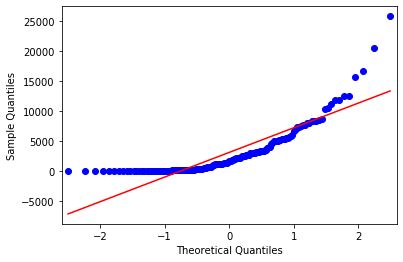

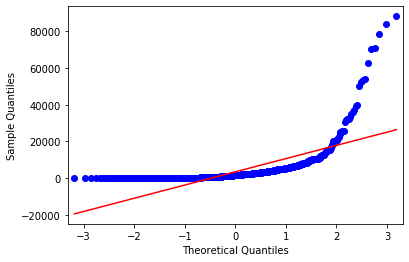

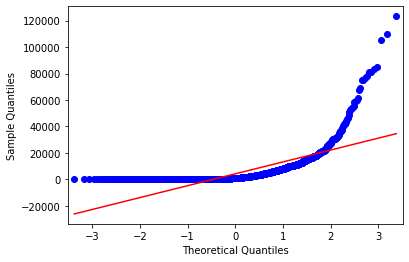

In [3]:
qqplot(performances['pledged'], line='s')
plt.show()

qqplot(theater['pledged'], line='s')
plt.show()

qqplot(music['pledged'], line='s')
plt.show()

Not looking too normal based on those plots... a non-parametric ANOVA test is the Kruskal Wallis test.  This uses the ranks of our data values rather than the values themselves a good write-up/example of this can be found [here](https://www.statisticshowto.datasciencecentral.com/kruskal-wallis/).  The below list assumptions is from that linked resource.

> #### Assumptions for the Kruskal Wallis Test
> Your variables should have:
>
> * One independent variable with two or more levels (independent groups). The test is more commonly used when you have three or more levels. For two levels, consider using the Mann Whitney U Test instead.
> * Ordinal scale, Ratio Scale or Interval scale dependent variables.
> * Your observations should be independent. In other words, there should be no relationship between the members in each group or between groups.
> * All groups should have the same shape distributions.

One way to examine the shape could be a histogram.  As seen below, we're roughly the same shape.

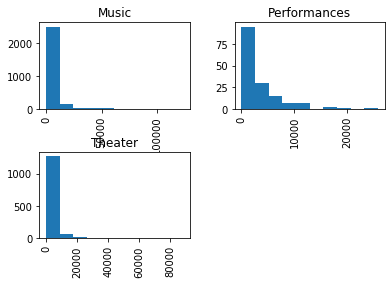

In [4]:
ks['pledged'].hist(by=ks['category'])
plt.show()

Let's move on to performing the test with `scipy.stats`.  Note, that we call this the same way as `stats.f_oneway` (for performing an ANOVA with `scipy.stats`).

In [5]:
test_statistic, p_value = stats.kruskal(performances['pledged'], theater['pledged'], music['pledged'])
print(f'p value < 0.05? {p_value < 0.05} (p = {p_value:.4f})')

p value < 0.05? True (p = 0.0001)


So we've concluded at least one median is different.  Time for some post hoc analysis.  We'll be doing multiple tests to determine this, so we'll need to correct for it.

In [14]:
u1, p_value_1 = stats.mannwhitneyu(performances['pledged'], theater['pledged'])
u2, p_value_2 = stats.mannwhitneyu(performances['pledged'], music['pledged'])
u3, p_value_3 = stats.mannwhitneyu(theater['pledged'], music['pledged'])

# Could possibly reuse kruskal wallis to acheive same results, kruskal wallis is
# a generalization of the mann whitney test to extend it to n_groups > 2
# _, p_value_1 = stats.kruskal(performances['pledged'], theater['pledged'])
# _, p_value_2 = stats.kruskal(performances['pledged'], music['pledged'])
# _, p_value_3 = stats.kruskal(theater['pledged'], music['pledged'])

p_values = [p_value_1, p_value_2, p_value_3]
# See documentation for more info:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html
reject_ho, corr_p_values, sidak_alpha, bonf_alpha = multipletests(p_values, alpha=0.05)

Based on our analysis we found:
* The mean rank of at least one of our samples is significantly different than the others
* There is a significant difference in mean rank between the amount pledged for theater and the amount pledged for music